1. Trend-based KNN from thesis is quite different, we'll start from basic KNN implementation

2. This to be the implementation witrh some technical indicators
https://www.youtube.com/watch?v=XK2IU5vRJr0
https://www.youtube.com/watch?v=yEyG8rYM9J4


In [32]:
import numpy as np 
import pandas_ta as ta
import yfinance as yf
amd = yf.download("USDCHF=X", interval="1d", progress=False)
amd.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-09-17,1.3814,1.3840,1.3743,1.3807,1.3807,0
2003-09-18,1.3802,1.3868,1.3747,1.3858,1.3858,0
2003-09-19,1.3856,1.3865,1.3653,1.3669,1.3669,0
2003-09-22,1.3563,1.3632,1.3502,1.3528,1.3528,0
2003-09-23,1.3527,1.3597,1.3419,1.3587,1.3587,0


In [33]:
amd.reset_index(inplace=True)
# amd.set_index("Date", inplace=True)
# amd.drop("level_0", axis=1, inplace=True)
# amd.drop("index", axis=1, inplace=True)
amd.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2003-09-17,1.3814,1.3840,1.3743,1.3807,1.3807,0
1,2003-09-18,1.3802,1.3868,1.3747,1.3858,1.3858,0
2,2003-09-19,1.3856,1.3865,1.3653,1.3669,1.3669,0
3,2003-09-22,1.3563,1.3632,1.3502,1.3528,1.3528,0
4,2003-09-23,1.3527,1.3597,1.3419,1.3587,1.3587,0


In [ ]:
# indexZero = amd[amd['Volume']==0].index
# amd.drop(indexZero, inplace=True)
# amd.isna().sum()
# amd

In [34]:
amd["ATR"] = amd.ta.atr(length=20)
amd["RSI"] = amd.ta.rsi() # default: 14
amd["Average"] = amd.ta.midprice(length=1)
amd['MA40'] = amd.ta.sma(length=40)
amd['MA80'] = amd.ta.sma(length=80)
amd['MA160'] = amd.ta.sma(length=160)

from scipy.stats import linregress
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope

# 
backrollingN = 6
# raw = True => return np.array; False=> return pd.Series
amd['slope_MA40'] = amd['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
amd['slope_MA80'] = amd['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
amd['slope_MA160'] = amd['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
amd['slope_MA40'] = amd['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
amd["slope_Average"] = amd['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
amd["slope_RSI"] = amd['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)
amd.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,ATR,RSI,Average,MA40,MA80,MA160,slope_MA40,slope_MA80,slope_MA160,slope_Average,slope_RSI
0,2003-09-17,1.3814,1.3840,1.3743,1.3807,1.3807,0,NaN,NaN,1.37915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003-09-18,1.3802,1.3868,1.3747,1.3858,1.3858,0,NaN,NaN,1.38075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003-09-19,1.3856,1.3865,1.3653,1.3669,1.3669,0,NaN,NaN,1.37590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003-09-22,1.3563,1.3632,1.3502,1.3528,1.3528,0,NaN,NaN,1.35670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003-09-23,1.3527,1.3597,1.3419,1.3587,1.3587,0,NaN,NaN,1.35080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2003-09-24,1.3584,1.3593,1.3407,1.3520,1.3520,0,NaN,NaN,1.35000,NaN,NaN,NaN,NaN,NaN,NaN,-0.007280,NaN
6,2003-09-25,1.3519,1.3542,1.3412,1.3447,1.3447,0,NaN,NaN,1.34770,NaN,NaN,NaN,NaN,NaN,NaN,-0.007110,NaN
7,2003-09-26,1.3445,1.3487,1.3410,1.3425,1.3425,0,NaN,NaN,1.34485,NaN,NaN,NaN,NaN,NaN,NaN,-0.005230,NaN
8,2003-09-29,1.3453,1.3594,1.3198,1.3236,1.3236,0,NaN,NaN,1.33960,NaN,NaN,NaN,NaN,NaN,NaN,-0.003019,NaN
9,2003-09-30,1.3228,1.3336,1.3097,1.3175,1.3175,0,NaN,NaN,1.32165,NaN,NaN,NaN,NaN,NaN,NaN,-0.005137,NaN


In [37]:
#Target flexible way
pipdiff = 500*1e-5 #for TP
SLTPRatio = 2 #pipdiff/Ratio gives SL

def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['High'])
    low = list(df1['Low'])
    close = list(df1['Close'])
    open = list(df1['Open'])
    trendcat = [None] * length
    
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat
amd['mytarget'] = mytarget(16, amd)
amd.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ATR,RSI,Average,MA40,MA80,MA160,slope_MA40,slope_MA80,slope_MA160,slope_Average,slope_RSI,mytarget
0,2003-09-17,1.3814,1.3840,1.3743,1.3807,1.3807,0,NaN,NaN,1.37915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2003-09-18,1.3802,1.3868,1.3747,1.3858,1.3858,0,NaN,NaN,1.38075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,2003-09-19,1.3856,1.3865,1.3653,1.3669,1.3669,0,NaN,NaN,1.37590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,2003-09-22,1.3563,1.3632,1.3502,1.3528,1.3528,0,NaN,NaN,1.35670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,2003-09-23,1.3527,1.3597,1.3419,1.3587,1.3587,0,NaN,NaN,1.35080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


C:\Users\p3749\AppData\Local\Temp\ipykernel_24832\1012699183.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_model.hist(ax = ax)


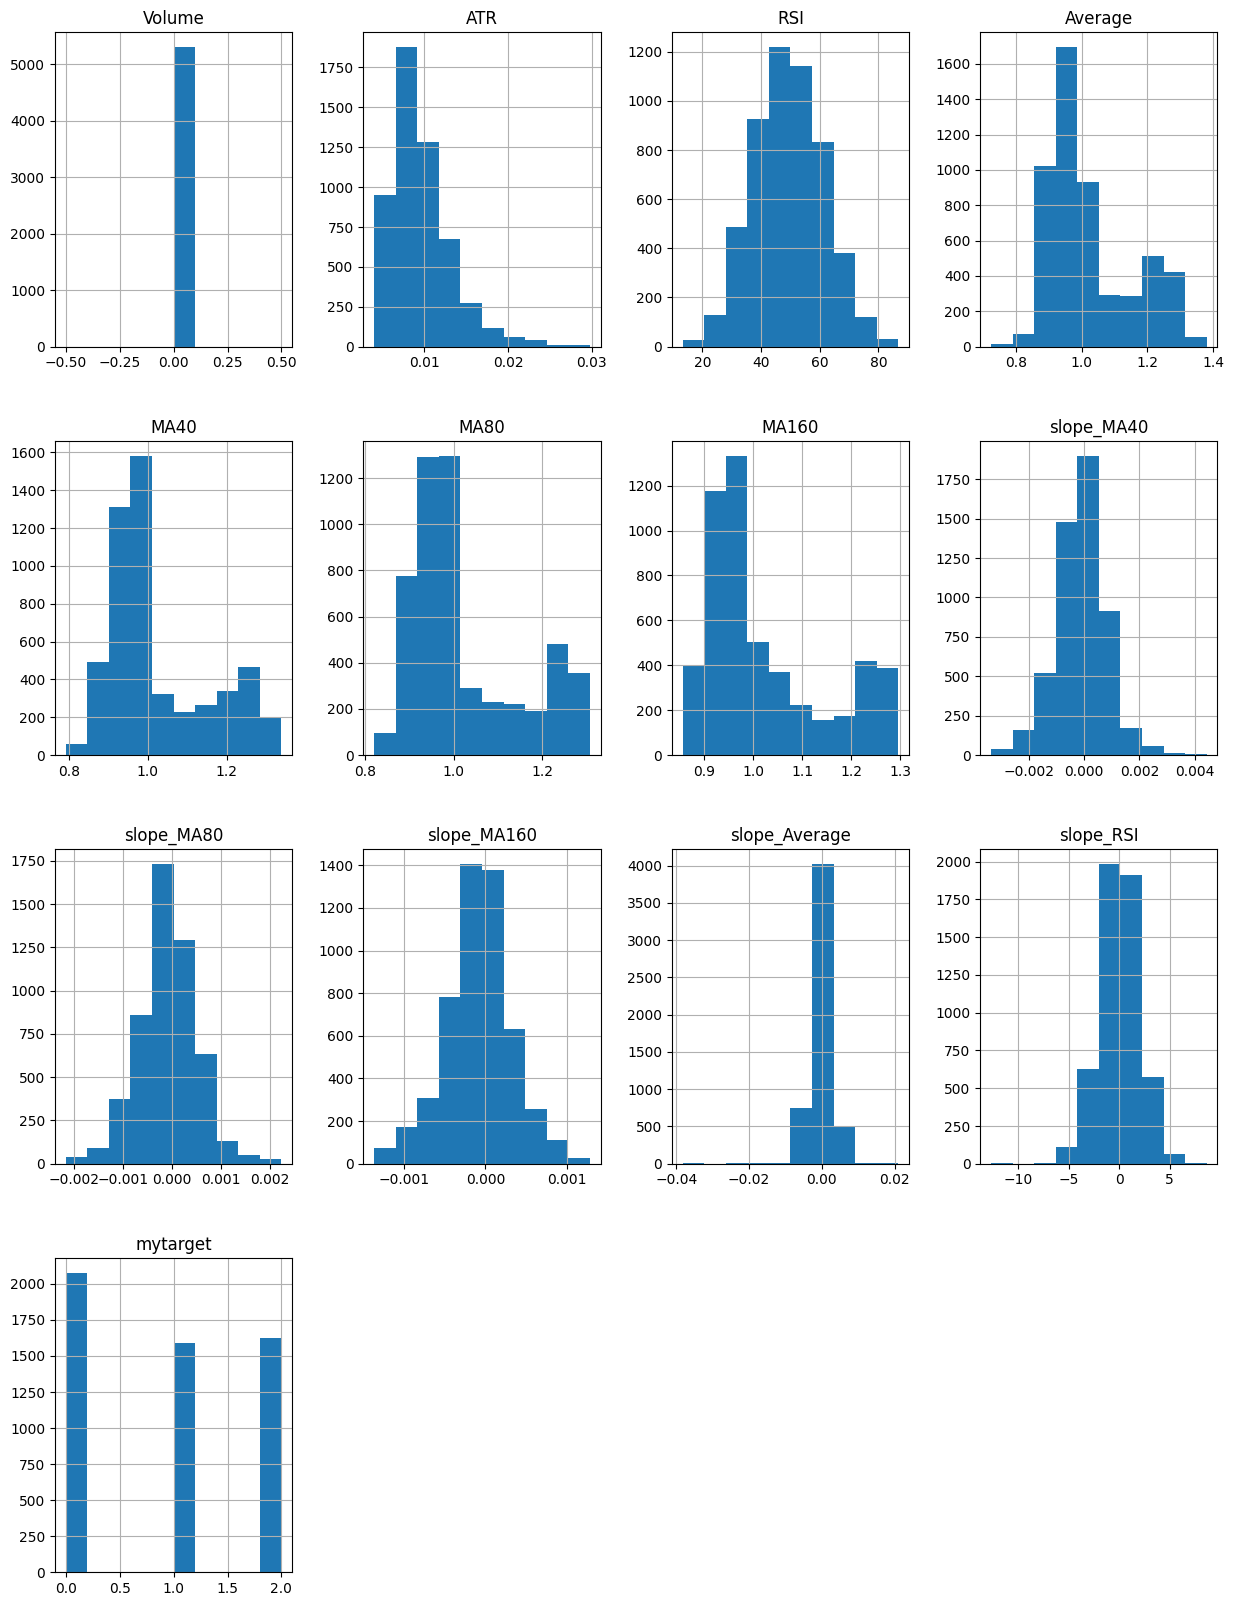

In [39]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_model= amd[['Volume', 'ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slope_MA40', 'slope_MA80', 'slope_MA160', 'slope_Average', 'slope_RSI', 'mytarget']] 
df_model.hist(ax = ax)
plt.show()

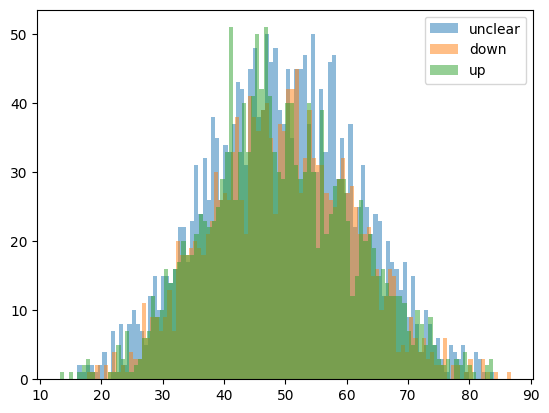

In [40]:
from matplotlib import pyplot
df_up=amd.RSI[amd['mytarget'] == 2 ]
df_down=amd.RSI[amd['mytarget'] == 1 ]
df_unclear=amd.RSI[amd['mytarget'] == 0 ]
pyplot.hist(df_unclear, bins=100, alpha=0.5, label='unclear')
pyplot.hist(df_down, bins=100, alpha=0.5, label='down')
pyplot.hist(df_up, bins=100, alpha=0.5, label='up')

pyplot.legend(loc='upper right')
pyplot.show()

In [41]:
df_up

17      30.399532
19      35.337317
22      43.375737
31      51.555099
47      35.529756
          ...    
5278    23.347883
5282    37.920656
5284    42.011578
5285    40.151579
5286    40.919863
Name: RSI, Length: 1626, dtype: float64